#  Neural Network for Part of Speach ( POS ) tagging 

Using Tensor Flow and Keras 

In [65]:
# Ensure reproducibility

import numpy as np

CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

In [66]:
import nltk
nltk.download('treebank')

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\a.pawlickamaule\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


True

In [67]:
import random
from nltk.corpus import treebank

sentences = treebank.tagged_sents(tagset='universal')
print('a random sentence: \n-> {}'.format(random.choice(sentences)))

a random sentence: 
-> [('These', 'DET'), ('nations', 'NOUN'), (',', '.'), ('known', 'VERB'), ('*', 'X'), ('as', 'ADP'), ('Asia', 'NOUN'), ("'s", 'PRT'), ('``', '.'), ('little', 'ADJ'), ('tigers', 'NOUN'), (',', '.'), ("''", '.'), ('also', 'ADV'), ('are', 'VERB'), ('contributing', 'VERB'), ('to', 'PRT'), ('Southeast', 'NOUN'), ('Asia', 'NOUN'), ("'s", 'PRT'), ('integration', 'NOUN'), (',', '.'), ('but', 'CONJ'), ('their', 'PRON'), ('influence', 'NOUN'), ('will', 'VERB'), ('remain', 'VERB'), ('subordinate', 'ADJ'), ('to', 'PRT'), ('Japan', 'NOUN'), ("'s", 'PRT'), ('.', '.')]


In [69]:
tags = set([tag for sentence in treebank.tagged_sents() for _, tag in sentence])
print('nb_tags: {}\ntags: {}'.format(len(tags), tags))

nb_tags: 46
tags: {'PRP$', 'PDT', ',', 'UH', 'NN', 'FW', 'PRP', 'IN', '$', 'JJR', 'WP$', '.', 'CD', 'MD', 'POS', '-LRB-', 'CC', 'VBZ', 'DT', 'NNS', 'VB', 'RBR', 'WRB', 'VBP', 'TO', 'SYM', '#', 'NNPS', 'RP', '-RRB-', 'VBN', 'WP', 'JJ', 'WDT', 'RBS', ':', '``', 'JJS', '-NONE-', 'EX', 'RB', 'VBD', "''", 'VBG', 'NNP', 'LS'}


We use approximately 60% of the tagged sentences for training, 20% as the validation set and 20% to evaluate our model.

In [70]:
train_test_cutoff = int(.80 * len(sentences)) 
training_sentences = sentences[:train_test_cutoff]
testing_sentences = sentences[train_test_cutoff:]
 
train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

### Adding basic features 

### return a dictionary with features 

import re 

def add_features(sentence_terms, index):
    term = sentence_terms[index]
    pattern = re.compile('[0-9]+')

    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'is_a_number': True == bool( pattern.match(term) ),
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'suffix-ing':term[-3:] == 'ing', 
        'suffix-ed':term[-2:]== 'ed',
        'suffix-ous': term[-3:] == 'ous',
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

In [24]:
import re 

def add_features(sentence_terms, index):
    term = sentence_terms[index]
    pattern = re.compile('[0-9]+')

    return {
        'term': term,
        'is_capitalized': term[0].upper() == term[0],
        'suffix-ing':term[-3:] == 'ing', 
        'suffix-ed':term[-2:]== 'ed',
        'suffix-ous': term[-3:] == 'ous',
    }

In [72]:
def untag(tagged_sentence):
    """ 
    Remove the tag for each tagged term. 

    :param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]

def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.

    :param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return: 
    """
    X, y = [], []

    for pos_tags in tagged_sentences:
        for index, (term, class_) in enumerate(pos_tags):
            # Add basic NLP features for each sentence term
            X.append(add_features(untag(pos_tags), index))
            y.append(class_)
    return X, y

For training, validation and testing sentences, we split the attributes into X (input variables) and y (output variables).

In [73]:
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

Fit our DictVectorizer with our set of features

In [74]:
from sklearn.feature_extraction import DictVectorizer
 
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)

DictVectorizer(dtype=<class 'numpy.float64'>, separator='=', sort=True,
               sparse=False)

Convert dict features to vectors

In [75]:
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

Fit LabelEncoder with our list of classes

In [76]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)

LabelEncoder()

Encode class values as integers

In [77]:
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

Convert integers to dummy variables (one hot encoded)

In [78]:
from keras.utils import np_utils
 
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
y_val = np_utils.to_categorical(y_val)

Define a simple Keras sequential model

In [79]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def build_model(input_dim, hidden_neurons, output_dim):
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

Set model parameters and create a new sklearn classifier instance

In [80]:
from keras.wrappers.scikit_learn import KerasClassifier

model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 256,
    'output_dim': y_train.shape[1],
    'epochs': 1,
    'batch_size': 128,
    'verbose': 1,
    'validation_data': (X_val, y_val),
    'shuffle': True
}

clf = KerasClassifier(**model_params)

Finally, fit our classifier

In [81]:
hist = clf.fit(X_train, y_train)

Train on 61107 samples, validate on 19530 samples
Epoch 1/1
61107/61107 [==============================] - 314s 5ms/step - loss: 0.3665 - accuracy: 0.8909 - val_loss: 0.1527 - val_accuracy: 0.9492


In [82]:

print( hist.history )

{'val_loss': [0.15267579074332913], 'val_accuracy': [0.9492063522338867], 'loss': [0.36651904405229974], 'accuracy': [0.8908963]}


from keras.models import load_model
import os
dirpath = os.getcwd()
print( dirpath )
clf = load_model('.\Homework 2\Question 1\\bla.h5')

In [83]:
import matplotlib.pyplot as plt

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """

    blue = '#4287f5'
    yellow = '#f5f542'

    with plt.style.context('dark_background'):
        fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
        ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5,
                 label='training')
        ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, yellow,
                 linewidth=5, label='validation')
        ax1.set_xlabel('# epoch')
        ax1.set_ylabel('loss')
        ax1.tick_params('y')
        ax1.legend(loc='upper right', shadow=False)
        ax1.set_title('Model loss through #epochs', fontweight='bold')

        ### second graph 
        
        ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5,
                 label='training')
        ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, yellow,
                 linewidth=5, label='validation')
        ax2.set_xlabel('# epoch')
        ax2.set_ylabel('accuracy')
        ax2.tick_params('y')
        ax2.legend(loc='lower right', shadow=False)
        ax2.set_title('Model accuracy through #epochs', fontweight='bold')

    plt.tight_layout()
    plt.show()

In [62]:
import matplotlib.pyplot as plt

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """

    blue = '#4287f5'
    yellow = '#f5f542'

    with plt.style.context('dark_background'):
        fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
        ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5,
                 label='training')
        ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, yellow,
                 linewidth=5, label='validation')
        ax1.set_xlabel('# epoch')
        ax1.set_ylabel('loss')
        ax1.tick_params('y')
        ax1.legend(loc='upper right', shadow=False)
        ax1.set_title('Model loss #epochs 61107 samples 19530 validation, 4 additional features, 256 hidden neurons, 128 batch size, sgd optimizer', fontweight='bold')

        ### second graph 
        
        ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5,
                 label='training')
        ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, yellow,
                 linewidth=5, label='validation')
        ax2.set_xlabel('# epoch')
        ax2.set_ylabel('accuracy')
        ax2.tick_params('y')
        ax2.legend(loc='lower right', shadow=False)
        ax2.set_title('Model accuracy #epochs', fontweight='bold')

    plt.tight_layout()
    plt.show()

Plot model performance

In [55]:
clf.summary()

AttributeError: 'KerasClassifier' object has no attribute 'summary'

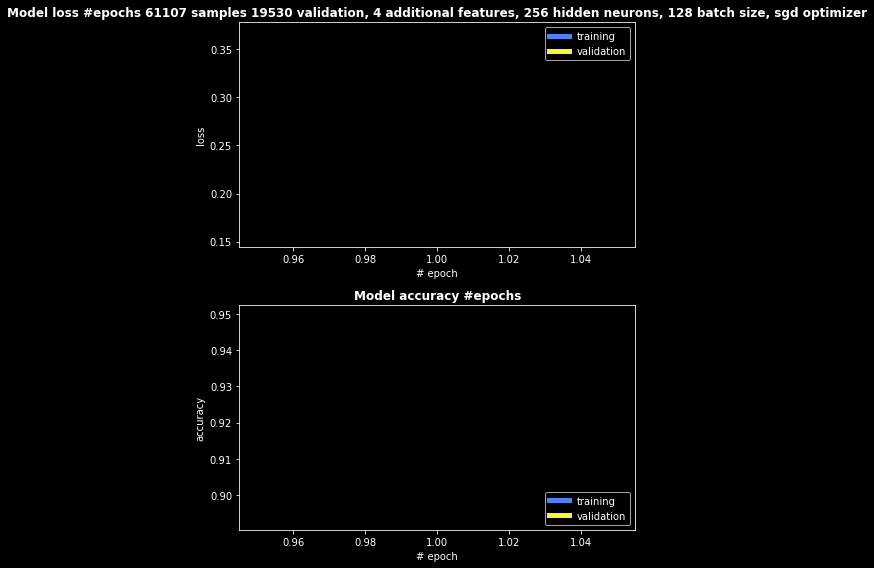

In [63]:

train_loss= hist.history.get('loss', [])

plot_model_performance(
    train_loss= hist.history.get('loss', []),
    train_acc = hist.history.get('accuracy', []),
    train_val_loss=hist.history.get('val_loss', []),
    train_val_acc = hist.history.get('val_accuracy', [])
)

In [84]:
score = clf.score(X_test, y_test, verbose=0)    
print('model accuracy: {}'.format(score))

model accuracy: 0.9609761238098145


Visualize model architecture

Finally, save model

In [0]:
from keras.utils import plot_model

plot_model(clf.model, to_file='./model_structure.png', show_shapes=True)

In [57]:
clf.model.save(".\Homework 2\Question 1\layers_256_batch_128_5epoch\\1_epoch_adam_19_features_keras_mlp_treebank_61107_samples_validate_19530_.h5")